In [1]:
from os.path import join
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.neighbors import NearestNeighbors
from sklearn.mixture import GaussianMixture
from sklearn.cluster import MeanShift, DBSCAN, estimate_bandwidth

## **Import Preprocessed Data**

In [2]:
df = pd.read_csv(join('..', 'data', 'data_preprocessed.csv'))

In [3]:
df.head()

,age,income,frq,rcn,mnt,clothes,kitchen,small_appliances,toys,house_keeping,...,oh_status_Widow,oh_gender_M,oh_dependents_1.0,oh_description_Kind of OK,oh_description_Meh...,oh_description_OK nice!,oh_description_Take my money!!,PC0,PC1,PC2
0,78,0.743162,1.191605,0.457819,1402,-0.617023,-0.243065,1.216847,0.495837,-0.499274,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.896356,-1.937697,1.120781
1,88,1.559488,1.100011,-1.535723,1537,0.166160,-0.790228,0.740464,-0.374374,-0.631907,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.981092,-1.421498,0.785625
2,34,-1.548542,-0.823463,0.557496,44,-0.834573,1.672006,-0.371096,-0.809480,2.286023,...,0.0,1.0,1.0,1.0,0.0,0.0,0.0,-2.813108,0.381440,-0.780867
3,69,0.845528,0.550447,-1.402820,888,0.383710,0.440889,-0.768082,-0.084304,-0.234007,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.247013,-0.514177,-1.302203
4,69,0.782435,1.008417,-0.871209,1138,0.340200,-0.243065,-0.053508,-0.374374,-0.366640,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.781920,-0.704805,-0.443376


In [4]:
df.columns

Index(['age', 'income', 'frq', 'rcn', 'mnt', 'clothes', 'kitchen',
       'small_appliances', 'toys', 'house_keeping', 'dependents',
       'per_net_purchase', 'gender', 'education', 'status', 'description',
       'birth_year', 'spent_online', 'oh_education_2nd Cycle',
       'oh_education_Graduation', 'oh_education_Master', 'oh_education_PhD',
       'oh_status_Married', 'oh_status_Single', 'oh_status_Together',
       'oh_status_Widow', 'oh_gender_M', 'oh_dependents_1.0',
       'oh_description_Kind of OK', 'oh_description_Meh...',
       'oh_description_OK nice!', 'oh_description_Take my money!!', 'PC0',
       'PC1', 'PC2'],
      dtype='object')

In [5]:
# Splitting feature names into groups
# Remember which metric_features we decided to keep?
metric_features = ['income',
 'frq',
 'rcn',
 'clothes',
 'kitchen',
 'small_appliances',
 'toys',
 'house_keeping',
 'per_net_purchase',
 'spent_online']

non_metric_features = df.columns[df.columns.str.startswith('oh_')].tolist()
pc_features = df.columns[df.columns.str.startswith('PC')].tolist()

unused_features = [i for i in df.columns if i not in (metric_features+non_metric_features+pc_features) ]

In [6]:
print('metric_features:', metric_features)
print('\nnon_metric_features:', non_metric_features)
print('\nunused_features:', unused_features)
print('\npc_features:', pc_features)


metric_features: ['income', 'frq', 'rcn', 'clothes', 'kitchen', 'small_appliances', 'toys', 'house_keeping', 'per_net_purchase', 'spent_online']

non_metric_features: ['oh_education_2nd Cycle', 'oh_education_Graduation', 'oh_education_Master', 'oh_education_PhD', 'oh_status_Married', 'oh_status_Single', 'oh_status_Together', 'oh_status_Widow', 'oh_gender_M', 'oh_dependents_1.0', 'oh_description_Kind of OK', 'oh_description_Meh...', 'oh_description_OK nice!', 'oh_description_Take my money!!']

unused_features: ['age', 'mnt', 'dependents', 'gender', 'education', 'status', 'description', 'birth_year']

pc_features: ['PC0', 'PC1', 'PC2']


In [7]:
def get_ss(df):
    """Computes the sum of squares for all variables given a dataset
    """
    ss = np.sum(df.var() * (df.count() - 1))
    return ss  # return sum of sum of squares of each df variable

---

# **Density Based Clustering**

<div class="alert alert-block alert-success" style="margin-top: 20px">

- Começa com várias seeds, faço um círculo à volta desse ponto, procuro o centroide nesse espaço e faço o shift <br>
- **Kmeans** após os pontos <br> 
- depende muito do **`bandwidth`**, mas pode ser estimado <br>
- robusto a outliers <br>
- nr of seeds <br>
- qual o tamanho da região para garantir um x nr de neighbors (p.e. quero 10% dos dados) <br><br>

**DBSCAN:** 
- combinação de variáveis faz com que seja **multivar. outlier**
</div>

## **Mean Shift Clustering**
What is Mean-shift clustering? How does it work?

Single seed             |  Multiple seeds
:-------------------------:|:-------------------------:
![](../figures/clustering/mean_shift_0.gif)  |  ![](../figures/clustering/mean_shift_tutorial.gif)
 
### **Characteristics:**
- No need to define number of clusters apriori
- Can detect clusters of any shape
- Robust to outliers
- Depends on the bandwidth hyperparameter (but there's a way to estimate it)
- **Main drawback**: Poor scalability (on both the algorithm and in estimating the bandwidth)

In [8]:
# The following bandwidth can be automatically detected using 
# # (we need to set quantile though)
# Based on distance to nearest neighbors for all observations

bandwidth = estimate_bandwidth(df[metric_features], 
# TO-DO: manipulate the quantile value such that we obtain a small enough bandwidth
                               # quantile=0.9,    # q = 0.9 -> 90% of the data is used to estimate the bandwidth (neighbors)  5.85
                               quantile=0.06,   # q = 0.06 -> 6% of the data is used to estimate the bandwidth (neighbors) -> Ela viu este valor em referências
                               random_state=1, 
                               n_jobs=-1)
bandwidth

2.3203034936185496

- **`quantile`** = end $\%$  of shortest distances  the biggger the quantile the bigger the distances
- **`n_jobs`** = number of paralele algorithms run at the same time 

### **How does `estimate_bandwidth` work?**

https://scikit-learn.org/1.5/modules/generated/sklearn.cluster.estimate_bandwidth.html#sklearn.cluster.estimate_bandwidth

Code from https://github.com/scikit-learn/scikit-learn/blob/6e9039160/sklearn/cluster/_mean_shift.py#L43

```python
    
    n_neighbors = int(X.shape[0] * quantile)
    if n_neighbors < 1:  # cannot fit NearestNeighbors with n_neighbors = 0
        n_neighbors = 1
    nbrs = NearestNeighbors(n_neighbors=n_neighbors, n_jobs=n_jobs)
    nbrs.fit(X)

    bandwidth = 0.0
    for batch in gen_batches(len(X), 500):
        d, _ = nbrs.kneighbors(X[batch, :], return_distance=True)
        bandwidth += np.max(d, axis=1).sum()

    return bandwidth / X.shape[0]
```


<div class="alert alert-block alert-info" style="font-size:16px">

### **Algorithm `estimate_bandwidth`:**

1. Specify `quantile`: 
    - Determines `n_neighbors`, which is how many neighbors to include when computing distances
2. Divide data into batches (for efficient calculation)
3. For each point, calculate `n_neighbors` Nearest Neighbors.
4. Get the largest distance to the `n_neighbors`
5. Get the average of these largest distances

> No final só queremos saber o quão grande é o raio que cobre a maioria dos pontos. (<span style="color:red">**circulo vermelho**</span>)

</div>

Mean Shift Algorithm, changing bandwidth values by modifying quantile values:

![](../figures/clustering/ms_quantile_bandwidth.png)


Mean Shift Algorithm, showing initial and final locations of seeds with varying bandwidth values.

![](../figures/clustering/ms_q_bw_start_end.png)


In [9]:
# Perform mean-shift clustering with bandwidth set using estimate_bandwidth
# TO-DO: explore the MeanShift class and obtain the cluster labels
# https://scikit-learn.org/stable/modules/generated/sklearn.cluster.MeanShift.html#sklearn.cluster.MeanShift

ms = MeanShift(bandwidth=bandwidth,     # Bandwidth to use
               bin_seeding=True,        # Use bin seeding to speed-up the algorithm
               n_jobs=-1)               # Use all available cores
ms_labels = ms.fit_predict(df[metric_features])

ms_n_clusters = len(np.unique(ms_labels))
print("Number of estimated clusters : %d" % ms_n_clusters)

Number of estimated clusters : 4


<div class="alert alert-block alert-danger" style="font-size:26px">

> Passou **1000 anos** a dizer para só usarmos **variáveis métricas**!

- A solução passa por utilizar **outras distâncias** que não as **Euclidean**.

In [10]:
# Concatenating the labels to df
df_concat = pd.concat([df[metric_features], pd.Series(ms_labels, index=df.index, name="ms_labels")], axis=1)
df_concat.head()

,income,frq,rcn,clothes,kitchen,small_appliances,toys,house_keeping,per_net_purchase,spent_online,ms_labels
0,0.743162,1.191605,0.457819,-0.617023,-0.243065,1.216847,0.495837,-0.499274,-1.257560,0.522055,0
1,1.559488,1.100011,-1.535723,0.166160,-0.790228,0.740464,-0.374374,-0.631907,-1.798649,-0.237578,0
2,-1.548542,-0.823463,0.557496,-0.834573,1.672006,-0.371096,-0.809480,2.286023,0.906799,-0.904191,0
3,0.845528,0.550447,-1.402820,0.383710,0.440889,-0.768082,-0.084304,-0.234007,-0.391816,0.785568,0
4,0.782435,1.008417,-0.871209,0.340200,-0.243065,-0.053508,-0.374374,-0.366640,-0.445925,1.237135,0


In [11]:
# Computing the R^2 of the cluster solution
sst = get_ss(df[metric_features])  # get total sum of squares
ssw_labels = df_concat.groupby(by='ms_labels')[metric_features].apply(get_ss)  # compute ssw for each cluster labels
ssb = sst - np.sum(ssw_labels)  # remember: SST = SSW + SSB
r2 = ssb / sst
print("Cluster solution with R^2 of %0.4f" % r2)

Cluster solution with R^2 of 0.2097


<div class="alert alert-block alert-warning" style="font-size:18px">

- Not the best solution to interpret clusters values - very small $R^2$

</div>

## **DBSCAN (Density-Based Spatial Clustering of Applications with Noise)**
What is DBSCAN clustering? How does it work?

DBSCAN animation            |  Core, border and noise
:-------------------------:|:-------------------------:
![](../figures/clustering/dbscan.gif)  |  ![](../figures/clustering/dbscan.jpg)



<div class="alert alert-block alert-warning" style="font-size:18px">

### **Types of Points:**

- **Core Points**: Points that have at least `min_samples` points within a distance of `epsilon`
- **Border Points**: Points that are within `epsilon` distance of a core point, but do not have enough neighbors to be considered core
- **Noise Points**: Points that are neither core nor border points


### **Characteristics:**
- No need to define number of clusters *apriori*
- Resistant to noise and outliers
- Can identify outliers
- Can handle clusters of different shapes and sizes
- Depends highly on the epsilon hyperparameter and it can be hard to tune
- Does not work well with clusters of varying densities

</div>  

<div class="alert alert-block alert-danger" style="font-size:18px">

## **Does not work well with clusters of varying densities**

> Deu o exemplo do circulo da direita ser usado no smile face. Não funciona bem porque o circulo da direita é muito grande para o smile face.

</div>

In [12]:
# Perform DBSCAN clustering
# TO-DO: explore the DBSCAN class and obtain the cluster labels
dbscan = DBSCAN(eps=1.9, 
                min_samples=20, 
                n_jobs=-1)
dbscan_labels = dbscan.fit_predict(df[metric_features]) 

dbscan_n_clusters = len(np.unique(dbscan_labels))
print("Number of estimated clusters : %d" % dbscan_n_clusters)

Number of estimated clusters : 2


<div class="alert alert-block alert-info" style="font-size:16px">

- **`dbscan = DBSCAN(eps=0.5, min_samples=5)`**
  - **`min_samples`**=> to have in order to consider a cluster ==> 
  - **`eps`**=0.5 ==> 37 clusters ==> my eplson is too small
  
</div>

In [13]:
np.unique(dbscan_labels)

array([-1,  0], dtype=int64)

In [14]:
#epson=0.5
from collections import Counter
Counter(dbscan_labels)

Counter({0: 8715, -1: 102})

DBSCAN Algorithm, varying epsilon and minpts values:

*Square markers are noise points* 

![](../figures/clustering/dbscan_eps_minpts.png)


<div class="alert alert-block alert" style="font-size:18px">

### Defining eps and min_samples:
- **MinPts**: As a rule of thumb, **minPts = 2 x dim** can be used, but it may be necessary to choose larger values for very large data, for noisy data or for data that contains many duplicates.

- **ε**: The value for ε can then be chosen by using a **k-distance graph**, plotting the distance to the kth (k = minPts - 1) nearest neighbor ordered from the largest to the smallest value. Good values of ε are where this plot shows an **"elbow"**: if ε is chosen much too small, a large part of the data will not be clustered; whereas for a too high value of ε, clusters will merge and the majority of objects will be in the same cluster. 

- The assumption is that for points in a cluster, **their k nearest neighbors are at roughly the same distance**. Noise points have their k-th nearest neighbors at farther distance


```python

# to define min_samples: 
df[metric_features].shape [1] *2

#actual ids
#point 0 20 neigh [   0, 1528, 8051, ..., 4477, 4327, 2837] the furter one is  2837 id

```

</div>

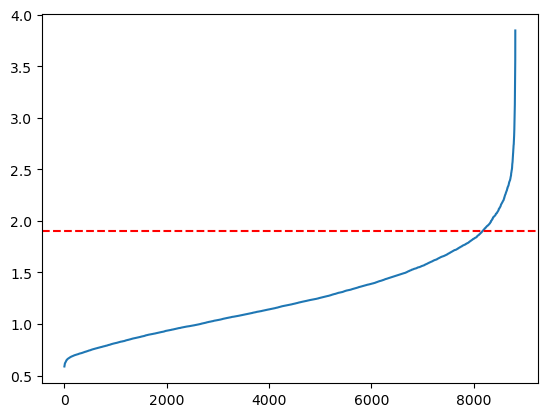

In [15]:
# K-distance graph to find out the right eps value
neigh = NearestNeighbors(n_neighbors=20)
neigh.fit(df[metric_features])
distances, _ = neigh.kneighbors(df[metric_features])
distances = np.sort(distances[:, -1])
plt.plot(distances)

# Put a horizontal line at y = 1.9
plt.axhline(y=1.9, color='r', linestyle='--')

plt.show()

<div class="alert alert-block alert-info" style="font-size:18px">

- Ela considerou $\epsilon =1.9$ pois a partir desse valor os pontos começam a ser ***outliers***.

In [16]:
# Concatenating the labels to df
df_concat = pd.concat([df[metric_features], pd.Series(dbscan_labels, index=df.index, name="dbscan_labels")], axis=1)
df_concat.head()

,income,frq,rcn,clothes,kitchen,small_appliances,toys,house_keeping,per_net_purchase,spent_online,dbscan_labels
0,0.743162,1.191605,0.457819,-0.617023,-0.243065,1.216847,0.495837,-0.499274,-1.257560,0.522055,0
1,1.559488,1.100011,-1.535723,0.166160,-0.790228,0.740464,-0.374374,-0.631907,-1.798649,-0.237578,0
2,-1.548542,-0.823463,0.557496,-0.834573,1.672006,-0.371096,-0.809480,2.286023,0.906799,-0.904191,0
3,0.845528,0.550447,-1.402820,0.383710,0.440889,-0.768082,-0.084304,-0.234007,-0.391816,0.785568,0
4,0.782435,1.008417,-0.871209,0.340200,-0.243065,-0.053508,-0.374374,-0.366640,-0.445925,1.237135,0


In [17]:
# Detecting noise (potential outliers)
# TO-DO: can we identify the noisy data? 
df_concat.loc[df_concat['dbscan_labels'] == -1]

,income,frq,rcn,clothes,kitchen,small_appliances,toys,house_keeping,per_net_purchase,spent_online,dbscan_labels
15,1.550018,2.199138,0.657173,-1.400205,-0.790228,0.502272,1.075978,3.214455,-1.041124,1.723881,-1
18,0.705467,-0.640275,-0.273146,-1.704776,-0.379855,-1.165068,3.976684,3.877621,-1.473995,-0.707594,-1
77,-0.409958,0.733635,1.255236,-1.226165,-0.653437,1.852024,2.381296,-0.897173,1.339671,2.022158,-1
154,-1.363078,-1.189839,1.554267,-1.791796,1.261634,-1.403260,1.656119,5.071320,-0.067162,-0.985227,-1
186,1.063291,-0.457087,1.521041,-1.313185,0.988052,-0.926877,1.221014,3.479722,0.095165,-0.175941,-1
...,...,...,...,...,...,...,...,...,...,...,...
8393,-0.014182,0.550447,1.487816,-1.487225,0.988052,1.296244,2.236260,-0.631907,0.960908,1.493886,-1
8487,1.072283,1.924356,1.354913,-1.574246,-0.653437,-0.053508,2.381296,3.347089,-1.149342,1.332468,-1
8591,0.294533,-1.464620,-0.339598,-1.530736,-0.516646,0.343478,2.816402,2.153390,-1.149342,-0.975972,-1
8803,0.687849,0.550447,-1.568948,-1.400205,4.407821,-0.291699,-0.519409,0.959691,-1.311668,0.033114,-1


In [18]:
# Computing the R^2 of the cluster solution
df_nonoise = df_concat.loc[df_concat['dbscan_labels'] != -1]
sst = get_ss(df[metric_features])  # get total sum of squares
ssw_labels = df_nonoise.groupby(by='dbscan_labels')[metric_features].apply(get_ss)  # compute ssw for each cluster labels
ssb = sst - np.sum(ssw_labels)  # remember: SST = SSW + SSB
r2 = ssb / sst
print("Cluster solution with R^2 of %0.4f" % r2)

Cluster solution with R^2 of 0.0339


<div class="alert alert-block alert-warning" style="font-size:18px">

> This $R^2$ não pode ser comparado com os outros pq é um datatset diferente, pois nos removemos dados e até bastantes $50000$. Mesmo só removendo os $53$ o seu $R^2$ não pode ser comparado  pq o datest é sempre diferente

</div>

- Why did the DBSCAN gave us just one cluster?
- What can we do with the noisy data?

<div class="alert alert-block alert-danger" style="font-size:20px">

- **Filipa:** DBSCAN PROVAVELMENTE NÃO VAI DAR BEM

</div>

## **GMM (Gaussian Mixture Model)**

What is GMM? How does it work?

![](../figures/clustering/gmm.gif)

--- 

$$\mathcal{p(\vec{x})} \ = \ \sum_{i=1}^K \phi_i \mathcal{N}(\vec{x}|\vec{\mu_i}, \Sigma_i) \tag{eq1}$$
$$\mathcal{N}(\vec{x}|\vec{\mu_i}, \Sigma_i) \ = \ \frac{1}{\sqrt{{(2\pi)}^{K}|\Sigma_i|}}e^{-\frac{1}{2} (\vec{x} - \vec{\mu_i})^T \Sigma_i^{-1} (\vec{x} - \vec{\mu_i})} \tag{eq2}$$
$$\sum_{i=1}^K \phi_i \ = \ 1 \tag{eq3}$$

, where:
- $\phi_i$ is the component weight (scalar) for Component $i$ (probability of an observation being generated by Component $i$)
- $\vec{\mu_i}$ is the mean vector for Component $i$,
- $\Sigma_i$ is the Covariance matrix for Component $i$

---

- **(eq1)** gives the probability of a point $x$ given the estimated Gaussian mixture
- **(eq2)** is the probability density function of a multivariate Gaussian with mean $\vec{\mu_i}$ and covariance $\Sigma_i$
- **(eq3)** states that the sum of the component weights is 1, such that the total probability distribution normalizes to 1

### **Characteristics:**
- Assumes the data is generated from a mixture of finite number of Gaussian distributions with unknown parameters
- Use the EM (Expectation Maximization algorithm) to estimate the parameters
- Provides a probability of each observation belonging to each cluster
- Advantages over K-Means:
    - Can deal with spherical and elipsoid cluster shapes
    - Number of components needs to be defined apriori
    

[Read More](https://jakevdp.github.io/PythonDataScienceHandbook/05.12-gaussian-mixtures.html)


<div class="alert alert-block alert-info" style="font-size:18px">

- Cada ponto tem uma certa **probabilidade** de pertencer a determinado cluster
- The centroids from **`KMeans`** are going to be the centroids in here to compute the **probabilities**

**Filipa**
- **SOB A ASSUMPTION** Assumes the data is generated from a mixture of finite number of Gaussian distributions with `Unknown` parameters consegue dar regiões que são elipses em vez de circunferências que encontro no ***k-means*** p.e.

</div>

In [19]:
# Performing GMM clustering
# https://scikit-learn.org/1.5/modules/generated/sklearn.mixture.GaussianMixture.html#sklearn.mixture.GaussianMixture

gmm = GaussianMixture(n_components=4, 
                      covariance_type='full', 
                      n_init=10, 
                      init_params='kmeans', 
                      random_state=1)
gmm_labels = gmm.fit_predict(df[metric_features])
labels_proba = gmm.predict_proba(df[metric_features])

**Let's look at the estimated parameters:**

In [20]:
# The estimated component weights
gmm.weights_

array([0.18452858, 0.2256973 , 0.33625179, 0.25352233])

In [21]:
# The estimated mean vectors of the Components
print(gmm.means_.shape)
gmm.means_

(4, 10)


array([[ 0.2530372 ,  0.3542025 , -0.0595048 ,  1.23402495, -0.73506377,
        -0.99459434, -0.74828104, -0.71166391,  0.33025043,  0.87154445],
       [-1.10240119, -0.9154974 ,  0.10659963, -1.03184762,  0.91961947,
         0.29598739,  0.90454949,  0.93327666,  0.6838511 , -0.83600729],
       [ 0.96947519,  0.93294459, -0.0541667 , -0.29120592,  0.12729172,
         0.33551101,  0.12950952,  0.08652077, -1.06536454,  0.48776013],
       [-0.48860148, -0.68017471,  0.02025358,  0.40663424, -0.45249437,
         0.01542804, -0.43239957, -0.42760909,  0.5638428 , -0.5370355 ]])

<div class="alert alert-block alert-success" style="font-size:18px">

- Each **row** are the **mean** for the components

- Each **matrix** are the **covariance** for the components

- Each **value** are the **weights** for the components

</div>

In [22]:
# The estimated covariance matrices of the Components
gmm.covariances_.shape

(4, 10, 10)

<div class="alert alert-block alert-warning" style="font-size:18px">

- **`(4, 10, 10)`** => **`4`** components, **`10`** features, **`10`** samples

### Defining covariance_type:
This hyperparameter controls the **degrees of freedom** in the shape of each cluster The more degrees of freedom we have the more complex shapes the model can fit and the more computationally expensive the model will be.

![](../figures/clustering/gmm_covariance.png)

- `covariance_type="tied"` makes all components share the same general covariance matrix

![](../figures/clustering/gmm_components_covars.png)

<div class="alert alert-block alert-danger" style="font-size:18px">

### **Defining `n_components`:**

**AIC**: estimates the relative amount of information lost by a model used to represent the data-generation process. ***The smaller the better.***

**BIC**: similar to AIC but penalizes more complex models (i.e. favors simpler models). ***The smaller the better.***

**A única coisa que precisamos de saber sobre estas métricas é que:**

<center> 

**Quanto menor melhor**

 </center>


</div>

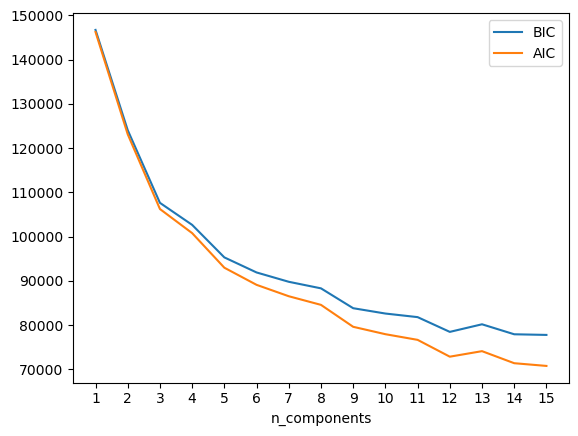

In [23]:
# This may take a while to run
# 
# Selecting number of components based on AIC and BIC
n_components = np.arange(1, 16)
models = [GaussianMixture(n, covariance_type='full', n_init=10, random_state=1).fit(df[metric_features])
          for n in n_components]

bic_values = [m.bic(df[metric_features]) for m in models]
aic_values = [m.aic(df[metric_features]) for m in models]
plt.plot(n_components, bic_values, label='BIC')
plt.plot(n_components, aic_values, label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components')
plt.xticks(n_components)
plt.show()

**Note**: the AIC and BIC measures can also be used to select diferent hyperparameters such as the covariance_type

<div class="alert alert-block alert-info" style="font-size:18px">

- **VER O COTOVELO**

</div>

In [24]:
# Performing GMM clustering
gmm = GaussianMixture(n_components=3, covariance_type='full', n_init=10, init_params='kmeans', random_state=1)
gmm_labels = gmm.fit_predict(df[metric_features])

In [25]:
# Concatenating the labels to df
df_concat = pd.concat([df[metric_features], pd.Series(gmm_labels, index=df.index, name="gmm_labels")], axis=1)
df_concat.head()

,income,frq,rcn,clothes,kitchen,small_appliances,toys,house_keeping,per_net_purchase,spent_online,gmm_labels
0,0.743162,1.191605,0.457819,-0.617023,-0.243065,1.216847,0.495837,-0.499274,-1.257560,0.522055,2
1,1.559488,1.100011,-1.535723,0.166160,-0.790228,0.740464,-0.374374,-0.631907,-1.798649,-0.237578,2
2,-1.548542,-0.823463,0.557496,-0.834573,1.672006,-0.371096,-0.809480,2.286023,0.906799,-0.904191,1
3,0.845528,0.550447,-1.402820,0.383710,0.440889,-0.768082,-0.084304,-0.234007,-0.391816,0.785568,2
4,0.782435,1.008417,-0.871209,0.340200,-0.243065,-0.053508,-0.374374,-0.366640,-0.445925,1.237135,0


In [26]:
# Computing the R^2 of the cluster solution
sst = get_ss(df[metric_features])  # get total sum of squares
ssw_labels = df_concat.groupby(by='gmm_labels')[metric_features].apply(get_ss)  # compute ssw for each cluster labels
ssb = sst - np.sum(ssw_labels)  # remember: SST = SSW + SSB
r2 = ssb / sst
print("Cluster solution with R^2 of %0.4f" % r2)

Cluster solution with R^2 of 0.3647


# **Clustering by Perspectives**
- Demographic Perspective:
- Value Perspective:
- Product Perspective:

## **Merging the Perspectives**
- How can we merge different cluster solutions?